In [1]:
import gzip
from collections import defaultdict
import math
import random
import numpy as np
import scipy.optimize

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

#reading data
rawdata=list(readGz("reviews_Electronics_5.json.gz"))

In [2]:
import string
import pandas as pd
def pad(c): return ' '+c
remove_table = str.maketrans({}.fromkeys(string.punctuation))
keep_table = str.maketrans({pun:pad(pun) for pun in string.punctuation})
table={True: remove_table, False:keep_table}

#clean the data before fitting
def clean(text,table,remove):
    return text.lower().translate(table[remove])

data=rawdata
for d in data:
    d['reviewText']=clean(d['reviewText'],table,True)
data=data[:50000]
df=pd.DataFrame.from_dict(data)
df.drop(columns=['helpful','reviewTime','reviewerID','reviewerName',
                 'summary','unixReviewTime'],inplace=True)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline=Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', linear_model.Ridge()),
])

params={'clf__alpha':[0.1,1,10,100,1000],
       'clf__fit_intercept':[True],
       'vect__max_features': [1000,2000,3000],
       'vect__stop_words':['english',None],
       'vect__ngram_range':[(1,1),(1,2),(1,3)]
       }
grid_search=GridSearchCV(pipeline, params,cv=3,verbose=1,
                         scoring='neg_mean_squared_error')
grid_search.fit(df.reviewText,df.overall)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 104.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': [0.1, 1, 10, 100, 1000], 'clf__fit_intercept': [True], 'vect__max_features': [1000, 2000, 3000], 'vect__stop_words': ['english', None], 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [4]:
grid_search.best_score_

-0.8014674783395286

In [5]:
grid_search.best_params_

{'clf__alpha': 1,
 'clf__fit_intercept': True,
 'vect__max_features': 3000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [6]:
res=pd.DataFrame(grid_search.cv_results_)

/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/an

In [7]:
res_n=res.fillna('None')
res_n.mean_train_score=-res_n.mean_train_score
res_n.mean_test_score=-res_n.mean_test_score

param_vect__stop_words  param_vect__max_features
None                    1000                        0.990365
                        2000                        0.954089
                        3000                        0.941580
english                 1000                        1.006596
                        2000                        0.978377
                        3000                        0.970917
Name: mean_test_score, dtype: float64

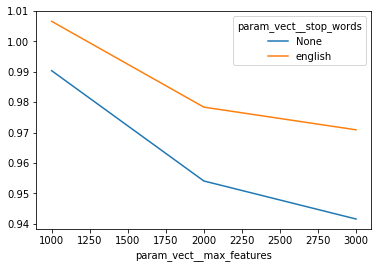

In [14]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__max_features']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score')
grouped['mean_test_score']

param_vect__stop_words  param_clf__alpha
None                    0.1                 0.859983
                        1.0                 0.849554
                        10.0                0.859501
                        100.0               1.017131
                        1000.0              1.223888
english                 0.1                 0.885266
                        1.0                 0.874659
                        10.0                0.880142
                        100.0               1.044428
                        1000.0              1.241989
Name: mean_test_score, dtype: float64

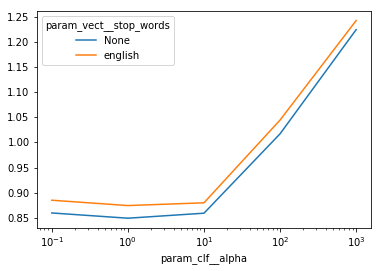

In [9]:
grouped=res_n.groupby(['param_vect__stop_words','param_clf__alpha']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score',logx=True)
grouped['mean_test_score']

param_vect__ngram_range  param_vect__max_features
(1, 1)                   1000                        0.994957
                         2000                        0.967147
                         3000                        0.962677
(1, 2)                   1000                        1.000180
                         2000                        0.965071
                         3000                        0.952223
(1, 3)                   1000                        1.000304
                         2000                        0.966482
                         3000                        0.953845
Name: mean_test_score, dtype: float64

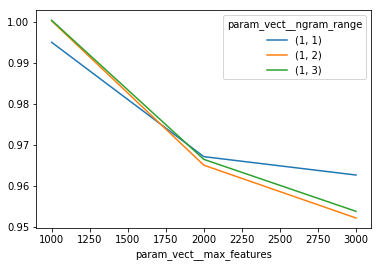

In [10]:
grouped=res_n.groupby(['param_vect__ngram_range','param_vect__max_features']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_test_score')
grouped['mean_test_score']

param_vect__ngram_range  param_clf__alpha
(1, 1)                   0.1                 0.874432
                         1.0                 0.863166
                         10.0                0.871418
                         100.0               1.032178
                         1000.0              1.233441
(1, 2)                   0.1                 0.870834
                         1.0                 0.860662
                         10.0                0.868307
                         100.0               1.029915
                         1000.0              1.232740
(1, 3)                   0.1                 0.872608
                         1.0                 0.862492
                         10.0                0.869739
                         100.0               1.030246
                         1000.0              1.232635
Name: mean_test_score, dtype: float64

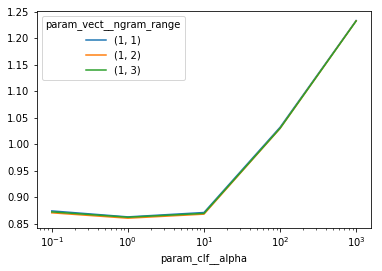

In [11]:
grouped=res_n.groupby(['param_vect__ngram_range','param_clf__alpha']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_test_score',logx=True)
grouped['mean_test_score']

param_vect__stop_words  param_vect__ngram_range  param_clf__alpha  param_vect__max_features
None                    (1, 1)                   0.1               1000                        0.897490
                                                                   2000                        0.842367
                                                                   3000                        0.836232
                                                 1.0               1000                        0.894820
                                                                   2000                        0.832633
                                                                   3000                        0.814291
                                                 10.0              1000                        0.896993
                                                                   2000                        0.845417
                                                                   3000     

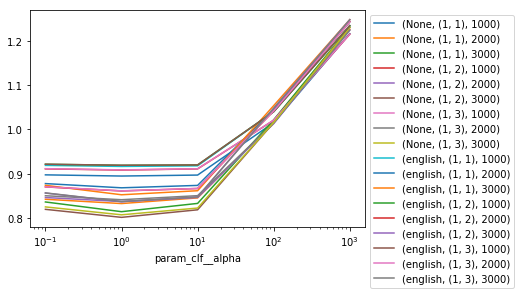

In [12]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__ngram_range','param_clf__alpha','param_vect__max_features']).mean()
ax=grouped.unstack('param_vect__stop_words').unstack('param_vect__ngram_range').unstack('param_vect__max_features').plot(y='mean_test_score',logx=True)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
grouped['mean_test_score']

In [13]:
grouped['mean_test_score'].to_csv("tfidf.txt", sep='\t')